In [46]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import string
from sklearn.metrics import accuracy_score, f1_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = "1"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#device = torch.device('cpu')
torch.set_default_device(device)

cuda


In [48]:
#from google.colab import drive
#drive.mount('/content/drive')

## Trenowanie i ewaluacja (generyczna funkcja)

In [49]:
##KOPIUJ WKLEJ Z GEMINI :))))))

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): Ile epok czekać po ostatniej poprawie.
                            Domyślnie: 7
            verbose (bool): Jeśli True, wypisuje komunikat dla każdej poprawy metryki walidacyjnej.
                            Domyślnie: False
            delta (float): Minimalna zmiana metryki walidacyjnej, aby uznać ją za poprawę.
                            Domyślnie: 0
            path (str): Ścieżka do zapisania checkpointu modelu.
                            Domyślnie: 'checkpoint.pt'
            trace_func (function): Funkcja do wypisywania komunikatów.
                            Domyślnie: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [50]:
def evaluate_model(model, test_dataloader):

    all_preds = []
    all_labels = []
    model.eval()  # Ustawiamy model w tryb ewaluacji
    print("\nPredictions on test data:")
    with torch.no_grad():  # Wyłączenie obliczania gradientów
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Pobranie przewidywanych klas

            all_preds.extend(predicted.cpu().numpy()) #należy przejść z GPU na CPU bo sklearn metrics działa na CPU
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted') # Lub inny, np. 'macro'

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test F1-Score: {f1:.4f}')

In [51]:
def trainAndEvaluate(model, train_dataloader, test_dataloader, dataset, num_epochs):
    early_stopping = EarlyStopping(patience=3, verbose=True)
    # 7. Konfiguracja treningu
    criterion = nn.CrossEntropyLoss()  # Funkcja straty dla klasyfikacji
    optimizer = optim.Adam(model.parameters(), lr=0.01)


    train_accuracies = []
    val_accuracies = []
    train_f1_scores = []
    val_f1_scores = []
    
    # 8. Pętla treningowa
    for epoch in range(num_epochs):
        model.train()  # Ustawienie modelu w tryb treningowy
        epoch_loss = 0.0
        correct = 0
        total = 0
        all_train_preds = []
        all_train_labels = []
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()         # Zerowanie gradientów
            outputs = model(inputs)         # Przepuszczamy dane przez model
            loss = criterion(outputs, labels)  # Obliczenie straty
            loss.backward()                 # Propagacja wsteczna
            # Gradient clipping - ograniczenie normy gradientów dla stabilności treningu
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()                # Aktualizacja wag

            epoch_loss += loss.item() * inputs.size(0)
            # Obliczenie predykcji: wybieramy indeks o najwyższej wartości z wyjścia
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
        
        avg_loss = epoch_loss / len(dataset)
        accuracy = correct / total
        train_accuracies.append(accuracy)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        train_f1_scores.append(train_f1)
        
        # Obliczanie val_loss na danych walidacyjnych (test_dataloader)
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f} - Val Accuracy: {val_accuracy:.4f} - Train F1: {train_f1} - Val F1: {val_f1:.4f}")

        # Sprawdzenie early stopping
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Wizualizacja metryk
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy na przestrzeni epok')
    plt.xlabel('Epoka')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1_scores, label='Train F1-Score')
    plt.plot(val_f1_scores, label='Validation F1-Score')
    plt.title('F1-Score na przestrzeni epok')
    plt.xlabel('Epoka')
    plt.ylabel('F1-Score')
    plt.legend()

    plt.show()

    evaluate_model(model, test_dataloader)





## Przygotowanie danych

In [52]:
def generateWordCloud(sentences):
    text = ''
    for x in sentences:
        if isinstance(x, str):
            text = text + ' ' + x

    print(text)   
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

WordCloud dla tekstu przed obróbką:
 i ve learned this lesson again open the package and use the product right away ordered this mouse in august as my travel mouse and just packed it away in my bag now ve been visiting family in the pnw since mid september the mouse took charge and worked fine for couple of weeks after recharged the mouse it worked for day or two and then ceased to function the optical light will flash once when turned on then nothing of course the return window is well past  it is so slow and lags find better option roller ball stopped working within months of minimal use piece of junk  i like the color and size but it few days out of the return period and it will not hold charge overall love this mouse the size weight clicking is all fabulous however ve had two of these now and the middle scroller has randomly fallen in without rough use it wasn dropped literally was not even touching it the second time and heard it fall if you need to use the middle scroller lot do 

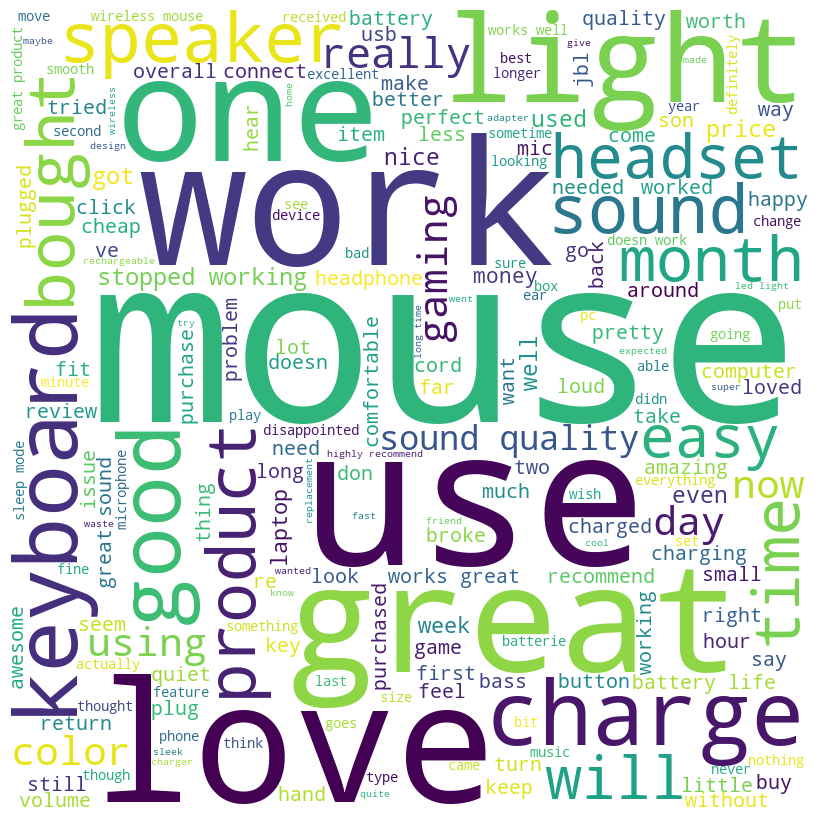

WordCloud dla tekstu po obróbce:
 learned lesson open package use product right away ordered mouse august travel mouse packed away bag visiting family pnw since mid september mouse took charge worked fine couple week recharged mouse worked day two ceased function optical light flash turned nothing course return window well past slow lag find better option roller ball stopped working within month minimal use piece junk like color size day return period hold charge overall love mouse size weight clicking fabulous however two middle scroller randomly fallen without rough use dropped literally even touching second time heard fall need use middle scroller lot recommend purchase use feature great mouse stopped working son us school issued chromebook school work hate using touch pad navigate mouse looked wireless mouse found one many good review unfortunately scrolling wheel already broken used month since us school computer mostly stayed stored safely carrying case rough stored carefully use

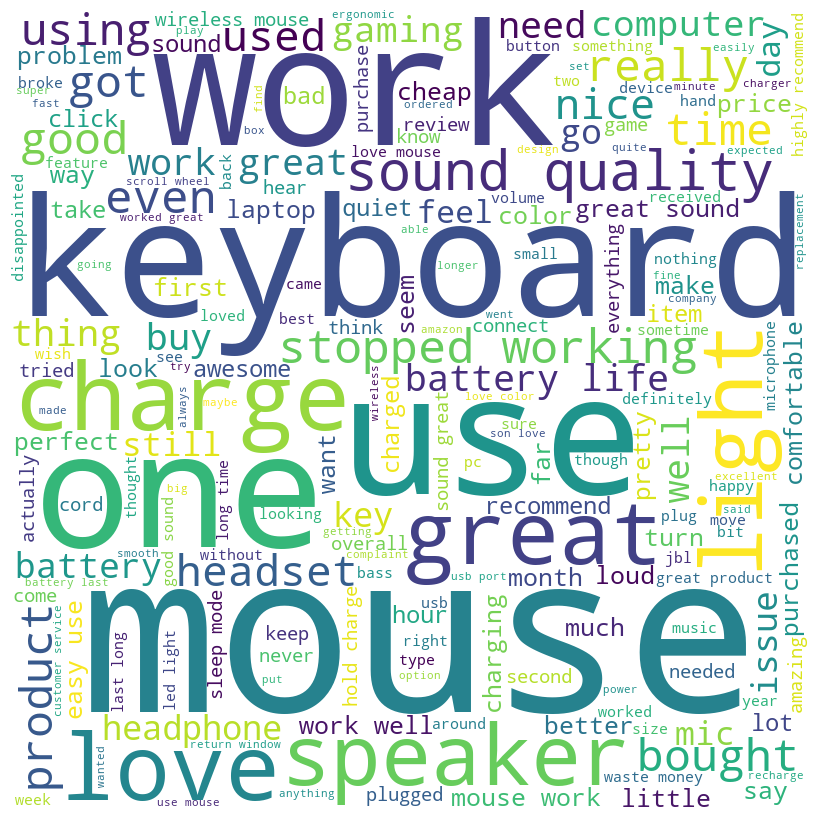

In [53]:
df = pd.read_csv("./amazon_reviews.csv")

# 1. Przygotowanie przykładowego zbioru danych
X = df.iloc[1:, 1].values
y = df.iloc[1:, 0].values

print("WordCloud dla tekstu przed obróbką:")
generateWordCloud(np.array(X))


stop_words = set(stopwords.words('english'))

def preprocess(text):
    if isinstance(text, float):
        text = str(' ')
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_words

processed_documents = [preprocess(doc) for doc in X]

print("WordCloud dla tekstu po obróbce:")
flat_list = [word for sublist in processed_documents for word in sublist]
generateWordCloud(flat_list)

# Kodowanie etykiet
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
data = list(zip(X, y))
data = [(str(text), int(label)) for text, label in data]

# 2. Budowanie słownika (vocab) - przypisujemy każdemu słowu unikalny indeks
def build_vocab(sentences):
    vocab = {}
    idx = 1  # Indeks 0 zarezerwowany na padding
    for sentence in sentences:
      if isinstance(sentence, float):
        sentence = str(' ')
      for word in sentence.lower().split():
        if word not in vocab:
            vocab[word] = idx
            idx += 1
    return vocab

sentences = [s for s, _ in data]
vocab = build_vocab(sentences)
vocab_size = len(vocab) + 1  # +1, aby uwzględnić token paddingu (indeks 0)

# 3. Tokenizacja i padding - ujednolicamy długość sekwencji
max_len = max(len(sentence.split()) for sentence, _ in data)

def tokenize_and_pad(sentence, vocab, max_len):
    tokens = [vocab.get(word, 0) for word in sentence.lower().split()]
    if len(tokens) < max_len:
        tokens += [0] * (max_len - len(tokens))
    else:
        tokens = tokens[:max_len]
    return tokens

# 4. Definicja klasy Dataset do obsługi danych tekstowych
class TextDataset(Dataset):
    def __init__(self, data, vocab, max_len):
        self.data = data
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence, label = self.data[idx]
        tokens = tokenize_and_pad(sentence, self.vocab, self.max_len)
        return torch.tensor(tokens, dtype=torch.long), torch.tensor(label, dtype=torch.long)

dataset = TextDataset(data, vocab, max_len)
generator = torch.Generator(device=device).manual_seed(42)

# Podział na zbiory treningowe i testowe
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

# DataLoader dla zbioru treningowego
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, generator=generator)

# DataLoader dla zbioru testowego
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, generator=generator)


## Simple RNN

In [54]:
# 5. Definicja modelu SimpleRNN do klasyfikacji tekstu
class SimpleRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(SimpleRNNClassifier, self).__init__()
        # Warstwa osadzenia (embedding) - przekształca indeksy słów w gęste wektory
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Prosta warstwa RNN - przetwarza sekwencje osadzeń
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
        # Warstwa w pełni połączona (fully connected) - przekształca ostatni stan ukryty do wyników klasyfikacji
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: tensor o kształcie [batch_size, seq_len]
        embedded = self.embedding(x)         # Przekształcamy indeksy na wektory - wynik [batch_size, seq_len, embed_size]
        output, hidden = self.rnn(embedded)    # Przechodzimy sekwencję przez RNN
                                               # output: wyjścia dla wszystkich kroków czasowych
                                               # hidden: ostatni stan ukryty (dla ostatniej warstwy)
        hidden = hidden[-1, :, :]              # Wybieramy ostatni stan z ostatniej warstwy, kształt [batch_size, hidden_size]
        out = self.fc(hidden)                  # Przepuszczamy przez warstwę liniową, uzyskując wyniki klasyfikacji
        return out

## LSTM

In [55]:
# 5. Definicja modelu LSTM do klasyfikacji tekstu
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        # Warstwa embedding zamieniająca indeksy słów na gęste wektory
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Warstwa LSTM - lepiej radzi sobie z długoterminowymi zależnościami
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        # Warstwa w pełni połączona, przekształcająca ostatni stan LSTM w wynik klasyfikacji
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: tensor o kształcie [batch_size, seq_len]
        embedded = self.embedding(x)   # [batch_size, seq_len, embed_size]
        # Przechodzimy przez LSTM; hidden_state oraz cell_state są zwracane jako krotka
        output, (hidden, cell) = self.lstm(embedded)
        # Wybieramy ostatni stan ukryty z ostatniej warstwy LSTM, który zawiera podsumowanie sekwencji
        hidden = hidden[-1, :, :]        # [batch_size, hidden_size]
        out = self.fc(hidden)            # [batch_size, output_size]
        return out

## BILSTM

In [56]:
# 5. Definicja modelu BLSTM (dwukierunkowy LSTM) do klasyfikacji tekstu
class BLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(BLSTMClassifier, self).__init__()
        # Warstwa embedding zamieniająca indeksy słów na wektory osadzeń
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Dwukierunkowy LSTM - bidirectional=True przetwarza sekwencje w obu kierunkach
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)
        # Warstwa w pełni połączona, która otrzymuje złączone stany z obu kierunków LSTM
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # x: tensor o kształcie [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_size]
        output, (hidden, cell) = self.lstm(embedded)
        # hidden: tensor o kształcie [num_layers * num_directions, batch_size, hidden_size]
        # Wybieramy ostatnią warstwę i łączymy stany z obu kierunków:
        # hidden[-2,:,:] - stan z kierunku forward
        # hidden[-1,:,:] - stan z kierunku backward
        hidden_forward = hidden[-2, :, :]
        hidden_backward = hidden[-1, :, :]
        hidden_combined = torch.cat((hidden_forward, hidden_backward), dim=1)  # [batch_size, hidden_size * 2]
        out = self.fc(hidden_combined)  # [batch_size, output_size]
        return out

# 6. Ustawienia modelu i hiperparametrów
embed_size = 10     # Rozmiar wektora osadzenia
hidden_size = 16    # Rozmiar stanu ukrytego LSTM
output_size = 3     # Liczba klas (binary classification)
num_layers = 2      # Liczba warstw LSTM

model = BLSTMClassifier(vocab_size, embed_size, hidden_size, output_size, num_layers)




## GRU

In [57]:
# 5. Definicja modelu GRU do klasyfikacji tekstu
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(GRUClassifier, self).__init__()
        # Warstwa embedding zamieniająca indeksy słów na wektory osadzeń
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Warstwa GRU przetwarza sekwencje osadzeń
        self.gru = nn.GRU(embed_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
        # Warstwa w pełni połączona, która przekształca ostatni stan GRU w wynik klasyfikacji
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: tensor o kształcie [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_size]
        # Przepuszczenie sekwencji przez GRU
        # 'output' zawiera wyjścia dla wszystkich kroków czasowych
        # 'hidden' to ostatni stan ukryty, kształt: [num_layers, batch_size, hidden_size]
        output, hidden = self.gru(embedded)
        # Wybieramy ostatni stan z ostatniej warstwy GRU
        hidden = hidden[-1, :, :]  # [batch_size, hidden_size]
        # Przepuszczenie stanu przez warstwę w pełni połączoną
        out = self.fc(hidden)  # [batch_size, output_size]
        return out

## BIGRU

In [58]:
class BIGRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(BIGRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigru = nn.GRU(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 dla dwukierunkowego GRU

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.bigru(embedded)
        # Bierzemy wyjście z ostatniego kroku czasowego dla każdego kierunku
        # (indeksy -1 i 0)
        output_forward = output[:, -1, :self.bigru.hidden_size]
        output_backward = output[:, 0, self.bigru.hidden_size:]
        output_combined = torch.cat((output_forward, output_backward), dim=1)
        output = self.fc(output_combined)
        return output

# Trenowanie, predykcja na danych testowych, analiza i prezentacja wyników

## Simple RNN

c:\Users\adria\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/20 - Loss: 0.7470 - Accuracy: 0.5428 - Val Accuracy: 0.5464 - Train F1: 0.40258494705443026 - Val F1: 0.3862
Validation loss decreased (inf --> 3184.122548).  Saving model ...
Epoch 2/20 - Loss: 0.7338 - Accuracy: 0.5431 - Val Accuracy: 0.5464 - Train F1: 0.40380338756677703 - Val F1: 0.3862
Validation loss decreased (3184.122548 --> 3182.315517).  Saving model ...
Epoch 3/20 - Loss: 0.7344 - Accuracy: 0.5440 - Val Accuracy: 0.5464 - Train F1: 0.3998860808154269 - Val F1: 0.3862
EarlyStopping counter: 1 out of 3
Epoch 4/20 - Loss: 0.7336 - Accuracy: 0.5434 - Val Accuracy: 0.5464 - Train F1: 0.404076409446702 - Val F1: 0.3862
EarlyStopping counter: 2 out of 3
Epoch 5/20 - Loss: 0.7337 - Accuracy: 0.5428 - Val Accuracy: 0.5464 - Train F1: 0.39830905022198304 - Val F1: 0.3862
EarlyStopping counter: 3 out of 3
Early stopping


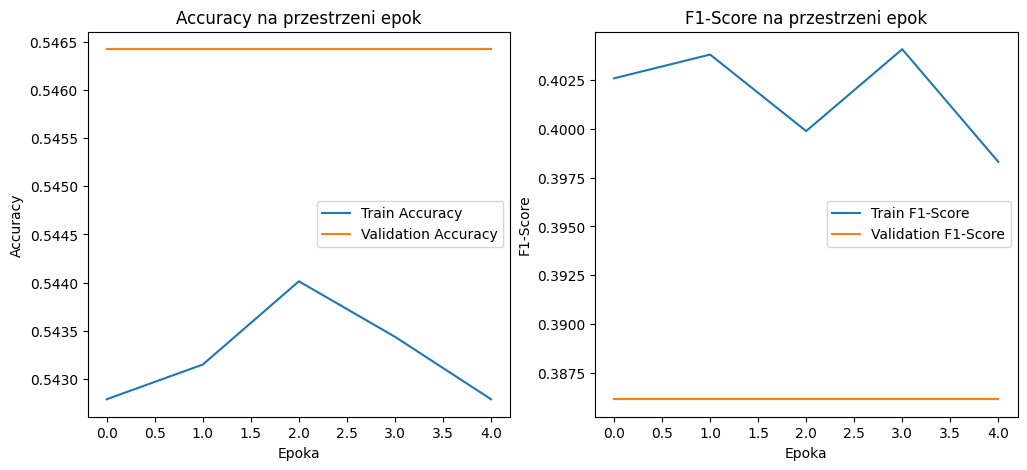


Predictions on test data:
Test Accuracy: 0.5464
Test F1-Score: 0.3862

==================DRUGI MODEL==================
Epoch 1/20 - Loss: 0.7513 - Accuracy: 0.5273 - Val Accuracy: 0.5464 - Train F1: 0.44332890337482384 - Val F1: 0.3862
Validation loss decreased (inf --> 3222.589880).  Saving model ...
Epoch 2/20 - Loss: 0.7465 - Accuracy: 0.5234 - Val Accuracy: 0.5464 - Train F1: 0.44102592449631955 - Val F1: 0.3862
Validation loss decreased (3222.589880 --> 3206.665605).  Saving model ...
Epoch 3/20 - Loss: 0.7535 - Accuracy: 0.5201 - Val Accuracy: 0.5464 - Train F1: 0.44240147824293313 - Val F1: 0.3862
EarlyStopping counter: 1 out of 3
Epoch 4/20 - Loss: 0.7480 - Accuracy: 0.5204 - Val Accuracy: 0.5464 - Train F1: 0.437190235275415 - Val F1: 0.3862
EarlyStopping counter: 2 out of 3
Epoch 5/20 - Loss: 0.7495 - Accuracy: 0.5173 - Val Accuracy: 0.3616 - Train F1: 0.4326924715541607 - Val F1: 0.1921
EarlyStopping counter: 3 out of 3
Early stopping


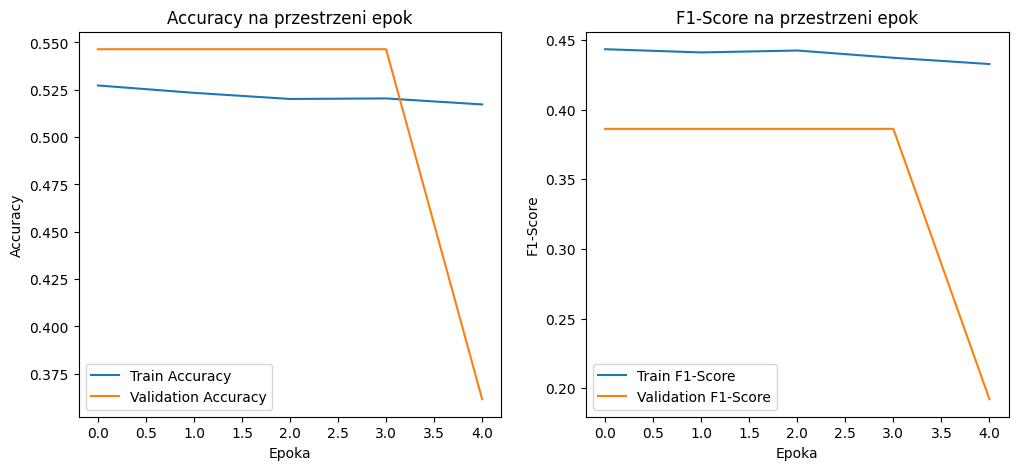


Predictions on test data:
Test Accuracy: 0.3616
Test F1-Score: 0.1921


In [59]:
model_simpleRNN_1 = SimpleRNNClassifier(vocab_size, embed_size = 10, hidden_size = 2, output_size = 16, num_layers = 1)
trainAndEvaluate(model_simpleRNN_1, train_dataloader, test_dataloader, dataset, 20)
print('')
print("==================DRUGI MODEL==================")
model_simpleRNN_2 = SimpleRNNClassifier(vocab_size, embed_size = 10, hidden_size = 10, output_size = 16, num_layers = 4)
trainAndEvaluate(model_simpleRNN_2, train_dataloader, test_dataloader, dataset, 20)

## LSTM

Epoch 1/20 - Loss: 0.7457 - Accuracy: 0.5403 - Val Accuracy: 0.5464 - Train F1: 0.4044236371834529 - Val F1: 0.3862
Validation loss decreased (inf --> 3193.105125).  Saving model ...
Epoch 2/20 - Loss: 0.7343 - Accuracy: 0.5447 - Val Accuracy: 0.5464 - Train F1: 0.3971416971629571 - Val F1: 0.3862
EarlyStopping counter: 1 out of 3
Epoch 3/20 - Loss: 0.7337 - Accuracy: 0.5441 - Val Accuracy: 0.5464 - Train F1: 0.40649348696703924 - Val F1: 0.3862
Validation loss decreased (3193.105125 --> 3184.933620).  Saving model ...
Epoch 4/20 - Loss: 0.7338 - Accuracy: 0.5435 - Val Accuracy: 0.5464 - Train F1: 0.40926378921116496 - Val F1: 0.3862
EarlyStopping counter: 1 out of 3
Epoch 5/20 - Loss: 0.7326 - Accuracy: 0.5473 - Val Accuracy: 0.5464 - Train F1: 0.3900719947887187 - Val F1: 0.3862
EarlyStopping counter: 2 out of 3
Epoch 6/20 - Loss: 0.7320 - Accuracy: 0.5474 - Val Accuracy: 0.5464 - Train F1: 0.3891964818690246 - Val F1: 0.3862
EarlyStopping counter: 3 out of 3
Early stopping


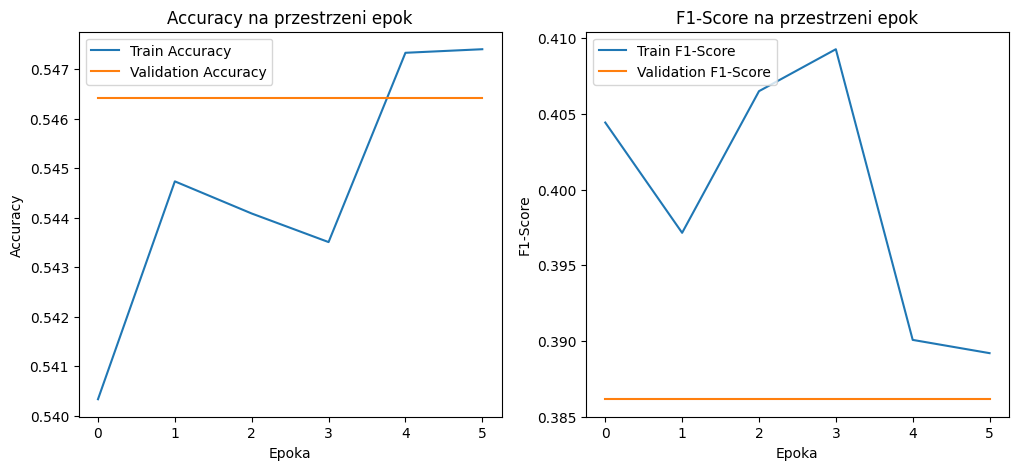


Predictions on test data:
Test Accuracy: 0.5464
Test F1-Score: 0.3862

==================DRUGI MODEL==================
Epoch 1/20 - Loss: 0.7447 - Accuracy: 0.5302 - Val Accuracy: 0.5464 - Train F1: 0.4288854170820738 - Val F1: 0.3862
Validation loss decreased (inf --> 3194.981881).  Saving model ...
Epoch 2/20 - Loss: 0.7383 - Accuracy: 0.5343 - Val Accuracy: 0.5464 - Train F1: 0.4284219765786535 - Val F1: 0.3862
EarlyStopping counter: 1 out of 3
Epoch 3/20 - Loss: 0.7376 - Accuracy: 0.5393 - Val Accuracy: 0.5464 - Train F1: 0.41144011450670365 - Val F1: 0.3862
Validation loss decreased (3194.981881 --> 3188.322246).  Saving model ...
Epoch 4/20 - Loss: 0.7356 - Accuracy: 0.5418 - Val Accuracy: 0.5464 - Train F1: 0.40544257396552846 - Val F1: 0.3862
EarlyStopping counter: 1 out of 3
Epoch 5/20 - Loss: 0.7359 - Accuracy: 0.5416 - Val Accuracy: 0.5464 - Train F1: 0.40432107276043566 - Val F1: 0.3862
EarlyStopping counter: 2 out of 3
Epoch 6/20 - Loss: 0.7359 - Accuracy: 0.5431 - Val Ac

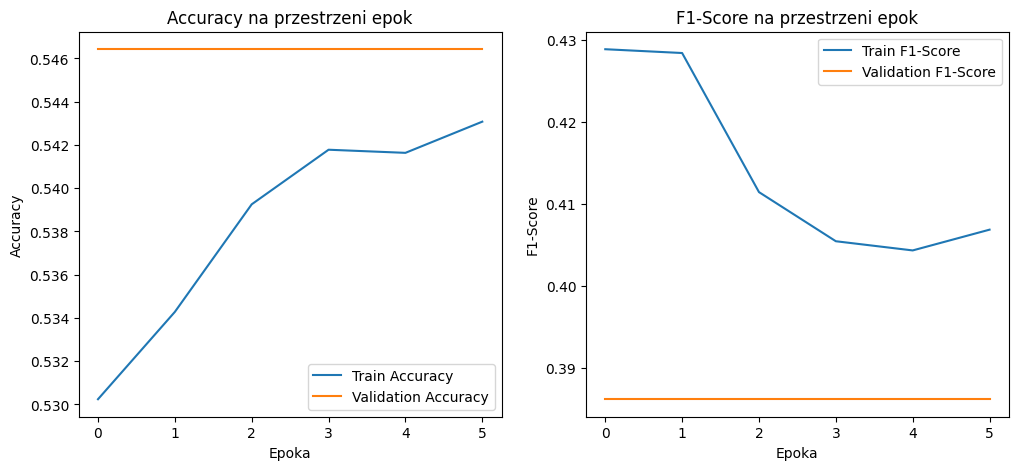


Predictions on test data:
Test Accuracy: 0.5464
Test F1-Score: 0.3862


In [60]:
model_lstm_1 = LSTMClassifier(vocab_size, embed_size= 10, hidden_size = 2, output_size = 16, num_layers = 2)
trainAndEvaluate(model_lstm_1, train_dataloader, test_dataloader, dataset, 20)
print('')
print("==================DRUGI MODEL==================")
model_lstm_2 = LSTMClassifier(vocab_size, embed_size= 10, hidden_size = 10, output_size = 16, num_layers = 8)
trainAndEvaluate(model_lstm_2, train_dataloader, test_dataloader, dataset, 20)


## BLSTM

Epoch 1/20 - Loss: 0.5956 - Accuracy: 0.6835 - Val Accuracy: 0.7543 - Train F1: 0.6491730528860129 - Val F1: 0.7634
Validation loss decreased (inf --> 2033.189338).  Saving model ...
Epoch 2/20 - Loss: 0.4012 - Accuracy: 0.7964 - Val Accuracy: 0.7909 - Train F1: 0.7757864649747581 - Val F1: 0.7612
Validation loss decreased (2033.189338 --> 1875.965371).  Saving model ...
Epoch 3/20 - Loss: 0.3594 - Accuracy: 0.8192 - Val Accuracy: 0.8010 - Train F1: 0.8032244862923159 - Val F1: 0.7687
Validation loss decreased (1875.965371 --> 1665.845021).  Saving model ...
Epoch 4/20 - Loss: 0.3243 - Accuracy: 0.8353 - Val Accuracy: 0.8270 - Train F1: 0.8216814498526658 - Val F1: 0.8062
Validation loss decreased (1665.845021 --> 1648.536531).  Saving model ...
Epoch 5/20 - Loss: 0.3014 - Accuracy: 0.8467 - Val Accuracy: 0.8120 - Train F1: 0.837071068289202 - Val F1: 0.7935
EarlyStopping counter: 1 out of 3
Epoch 6/20 - Loss: 0.2920 - Accuracy: 0.8538 - Val Accuracy: 0.8157 - Train F1: 0.8455242345510

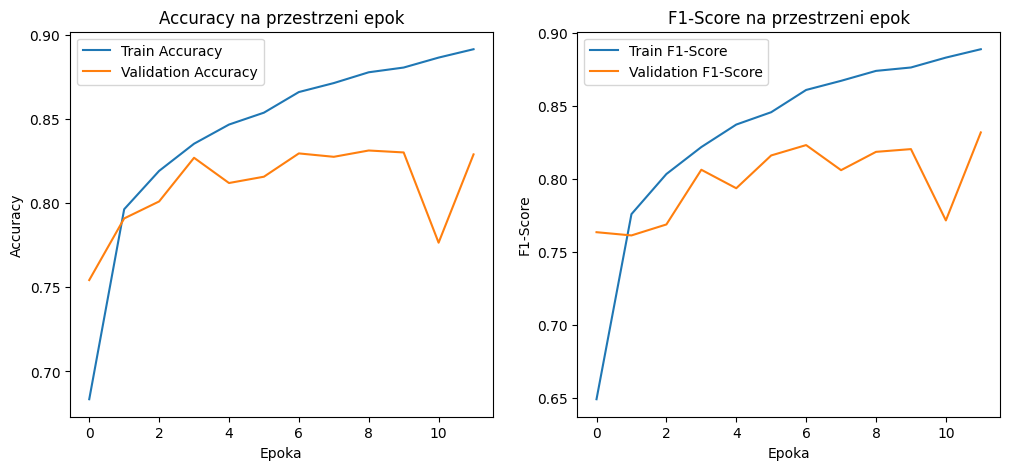


Predictions on test data:
Test Accuracy: 0.8290
Test F1-Score: 0.8317

==================DRUGI MODEL==================
Epoch 1/20 - Loss: 0.7414 - Accuracy: 0.5356 - Val Accuracy: 0.5464 - Train F1: 0.42843634268643477 - Val F1: 0.3862
Validation loss decreased (inf --> 3205.264515).  Saving model ...
Epoch 2/20 - Loss: 0.7348 - Accuracy: 0.5418 - Val Accuracy: 0.5464 - Train F1: 0.4011546901421483 - Val F1: 0.3862
Validation loss decreased (3205.264515 --> 3198.189440).  Saving model ...
Epoch 3/20 - Loss: 0.7342 - Accuracy: 0.5423 - Val Accuracy: 0.5464 - Train F1: 0.4038989696614684 - Val F1: 0.3862
Validation loss decreased (3198.189440 --> 3185.466503).  Saving model ...
Epoch 4/20 - Loss: 0.7336 - Accuracy: 0.5466 - Val Accuracy: 0.5464 - Train F1: 0.39351184845963577 - Val F1: 0.3862
Validation loss decreased (3185.466503 --> 3182.929269).  Saving model ...
Epoch 5/20 - Loss: 0.7338 - Accuracy: 0.5475 - Val Accuracy: 0.5464 - Train F1: 0.39200891148999095 - Val F1: 0.3862
Early

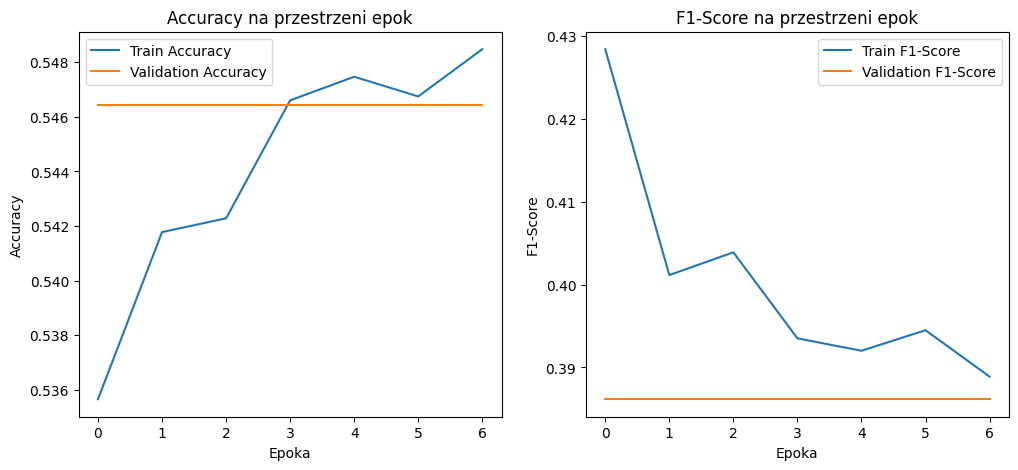


Predictions on test data:
Test Accuracy: 0.5464
Test F1-Score: 0.3862


In [61]:
model_blstm_1 = BLSTMClassifier(vocab_size, embed_size= 10, hidden_size = 2, output_size = 16, num_layers = 2)
trainAndEvaluate(model_blstm_1, train_dataloader, test_dataloader, dataset, 20)
print('')
print("==================DRUGI MODEL==================")
model_blstm_2 = BLSTMClassifier(vocab_size, embed_size= 10, hidden_size = 10, output_size = 16, num_layers = 8)
trainAndEvaluate(model_blstm_2, train_dataloader, test_dataloader, dataset, 20)

## GRU

Epoch 1/20 - Loss: 0.7456 - Accuracy: 0.5395 - Val Accuracy: 0.5464 - Train F1: 0.40261582293284853 - Val F1: 0.3862
Validation loss decreased (inf --> 3188.026343).  Saving model ...
Epoch 2/20 - Loss: 0.7330 - Accuracy: 0.5479 - Val Accuracy: 0.5464 - Train F1: 0.38867771463568146 - Val F1: 0.3862
EarlyStopping counter: 1 out of 3
Epoch 3/20 - Loss: 0.6688 - Accuracy: 0.6172 - Val Accuracy: 0.6753 - Train F1: 0.5795527749072245 - Val F1: 0.6492
Validation loss decreased (3188.026343 --> 2676.890720).  Saving model ...
Epoch 4/20 - Loss: 0.6030 - Accuracy: 0.6860 - Val Accuracy: 0.6964 - Train F1: 0.6591694569446567 - Val F1: 0.6694
Validation loss decreased (2676.890720 --> 2550.153082).  Saving model ...
Epoch 5/20 - Loss: 0.5474 - Accuracy: 0.7366 - Val Accuracy: 0.7099 - Train F1: 0.7061278707300539 - Val F1: 0.6826
Validation loss decreased (2550.153082 --> 2452.402035).  Saving model ...
Epoch 6/20 - Loss: 0.5142 - Accuracy: 0.7605 - Val Accuracy: 0.7630 - Train F1: 0.7277322967

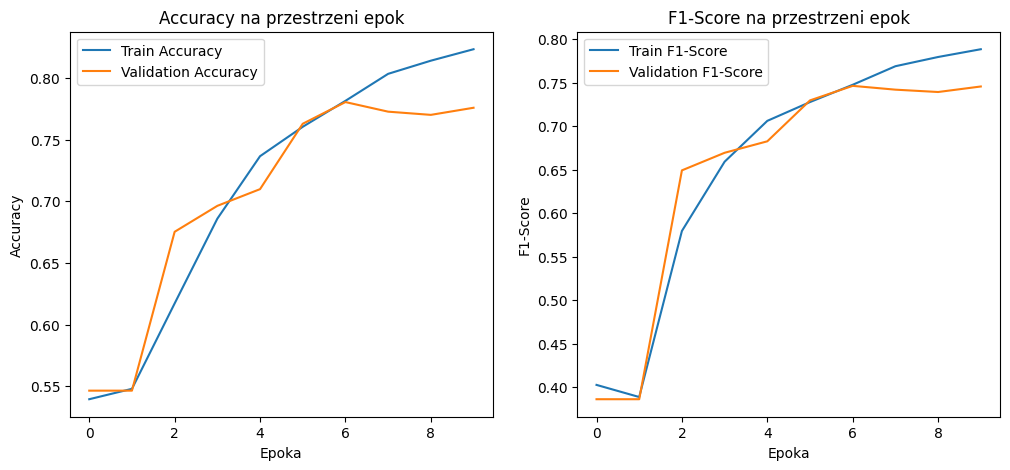


Predictions on test data:
Test Accuracy: 0.7760
Test F1-Score: 0.7456

==================DRUGI MODEL==================
Epoch 1/20 - Loss: 0.7452 - Accuracy: 0.5269 - Val Accuracy: 0.5464 - Train F1: 0.4382608527386907 - Val F1: 0.3862
Validation loss decreased (inf --> 3185.007973).  Saving model ...
Epoch 2/20 - Loss: 0.7399 - Accuracy: 0.5315 - Val Accuracy: 0.5464 - Train F1: 0.4258620731026169 - Val F1: 0.3862
EarlyStopping counter: 1 out of 3
Epoch 3/20 - Loss: 0.7390 - Accuracy: 0.5329 - Val Accuracy: 0.5464 - Train F1: 0.42413591367123793 - Val F1: 0.3862
EarlyStopping counter: 2 out of 3
Epoch 4/20 - Loss: 0.7438 - Accuracy: 0.5344 - Val Accuracy: 0.5464 - Train F1: 0.41855405035812626 - Val F1: 0.3862
EarlyStopping counter: 3 out of 3
Early stopping


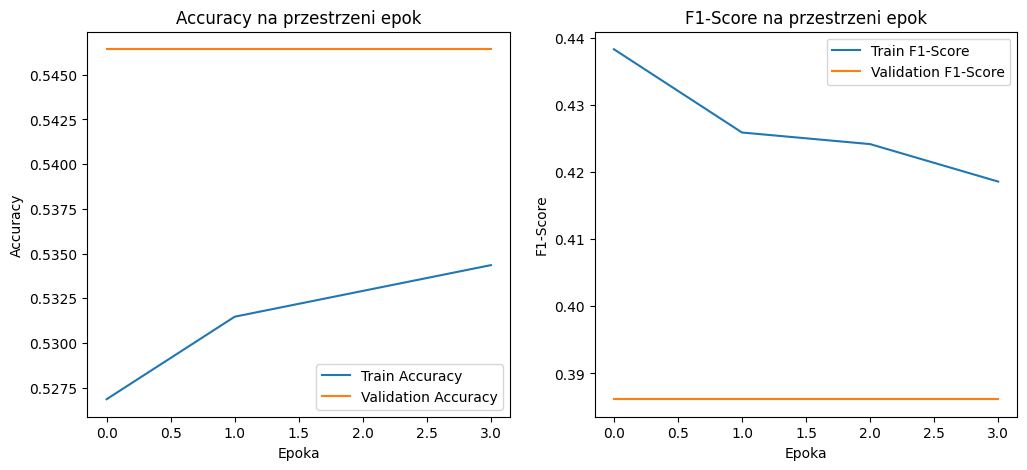


Predictions on test data:
Test Accuracy: 0.5464
Test F1-Score: 0.3862


In [62]:
model_gru_1 = GRUClassifier(vocab_size, embed_size= 10, hidden_size = 2, output_size = 16, num_layers = 2)
trainAndEvaluate(model_gru_1, train_dataloader, test_dataloader, dataset, 20)
print('')
print("==================DRUGI MODEL==================")
model_gru_2 = GRUClassifier(vocab_size, embed_size= 10, hidden_size = 10, output_size = 16, num_layers = 8)
trainAndEvaluate(model_gru_2, train_dataloader, test_dataloader, dataset, 20)

## BIGRU

In [63]:
model_bigru_1 = BIGRUClassifier(vocab_size, embed_size= 10, hidden_size = 2, output_size = 16, num_layers = 2)
trainAndEvaluate(model_bigru_1, train_dataloader, test_dataloader, dataset, 20)
print('')
print("==================DRUGI MODEL==================")
model_bigru_2 = BIGRUClassifier(vocab_size, embed_size= 10, hidden_size = 10, output_size = 16, num_layers = 8)
trainAndEvaluate(model_bigru_2, train_dataloader, test_dataloader, dataset, 20)

TypeError: BIGRUClassifier.__init__() got an unexpected keyword argument 'embed_size'